# Revisiting MLE

As you recall, for linear regressions, we estimate parameters by deploying some kind of least square technique, the usual suspect being the ordinary least squares (OLS). However, a logistic regression breaks one of the cardinal assumptions of OLS, namely the normality of the target (dependent) variable, given the fact that logistics are binary. 

Therefore, you'll recall that we have to deploy the apparatus of the MLE to do parameter estimation for the right-hand side of the equation. Recall that MLE seek to find the maximum probability given the data at hand. 

# Constructing the Logistic Regression 

As you recall, MLE's require a few ingredients, one is a well-defined likelihood function. Given, the fact that we are dealing with binary targets, we can easily model these using Bernoulli scheme: $$ P(x_i)^{r_i}(1-P(x_i)^{1-r_i})$$

Recall also that we seek to maximize the following: $$\prod_{i=1}^n P(x_i)^{r_i}(1-P(x_i)^{1-r_i})$$, yet because off the annoying property of computing the derivatives numerically, it's best to transform this with the logarithm, which makes this into computing a derivative of a product chain to computing a derivative of a sum: $$\sum_{i=1}^n [r_i * ln(P(x_i)) + (1-r_i)ln(1-P(x_i))]$$

A much "cleaner" functional form with respect to computing a derivative. From here, the problem is transferred to solving a constraint optimization problem. Rarely will you have to do this by hand, and we did some simple finger exercises previously for you to get the feel of it, but in general, the software will handle these in the background for you.

For those of you with the mathematical background, you should check up iterative numerical methods for least square problems.


# Some useful reserved words/functions in the Stan environment

**Remember** The Docs are your friends, use them, study them, read them always, at night, in the mornings, while you're eating lunch, while you're taking care of your baby, while you're on a date... **ALWAYS**. 

http://pystan.readthedocs.io/en/latest/api.html

# Reintroducing the Polling data

This case study will be based off of the data we used in Lab 1.4: http://www.stat.columbia.edu/~gelman/arm/examples/election88/, from the great one, Dr. Gelman, one of the foremost researchers in Bayesian analysis.
Recall, this election was ultimately a major victory for the Grand Old Party (GOP/Republicans), and propelled George H.W. Bush (the father of George W. Bush) into the presidency.
Import the data, and delete the Unnamed column

#### Problem 1

Load the data and check the first few observations to get a view of the data. Basically do what you did in the previous lab, you should be a champ at this by now !

In [10]:
from __future__ import division
import pystan
import os
import pylab as py
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4l
plt.style.use('ggplot')

new_poll = pd.read_csv('polls.csv')
# print(type(pre_poll))
new_poll.head(10)
del new_poll['Unnamed: 0']
new_poll['org'].value_counts()
del new_poll['org']
new_poll.head()

,year,survey,bush,state,edu,age,female,black,weight
0,1,9152,1,7,2,2,1,0,1403
1,1,9152,1,33,4,3,0,0,778
2,1,9152,0,20,2,1,1,0,1564
3,1,9152,1,31,3,2,1,0,1055
4,1,9152,1,18,3,1,1,0,1213


In [8]:
!pwd

/Users/jam3jam/dsi/GA-DSI/dsi-course-materials/curriculum/04-lessons/week-08/2.2-lab/code


Make sure you have the same length of the data set (you will) so you know the file hasn't changed (at least with respect to length). 

In [11]:
len(new_poll)

13544

# Building a Logistic Regression in PyStan

We're going use the old polling data differently today, we're going to build a bush-classifier. What does that mean? Since we have a column of data that is 1 for a polled for Bush, and 0 otherwise, we'll see if any of the data in the table are good predictors for someone who ended up polling for Papa Bush. 

The point of this exercise is not really to build a good predictor, but to gain more facility with the PyStan environment. So we're going to make some unrealstic assumptions in this first run so we can just get use to producing/constructing models with PyStan. 

For the PyStan model below, I want you to assume that all your parameters are normally distributed with 0 mean and variance 10. Realistic? No way. But it'll make the model specification go smoother. For those of you who want a challenge, after you get your first model working. Go back and think about what distributions you should use instead of normal to get a better fit. 

#### Problem 2

Construct the PyStan Logistic Regression model

In [12]:
log_reg_code = """
data {
    int<lower=0> n;
    int<lower=0> bush[n];
    int edu[n];
    int age[n];
    
}
transformed data {}
parameters {
    real a;
    real b;
    real constant;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    constant ~ normal(0, 10);
    for(i in 1:n) {
        bush[i] ~ bernoulli(inv_logit(a*edu[i] + b*age[i] + constant));
  }
}
generated quantities {}
"""


#### Problem 3

Build a dictionary for the 2-variate Pystan Logistic Regression and setup the Pystan model from the STAN C++ code written above, also print the model to observe the quartile and other summary stats. After, output the traceplot to observe the parameter graphs

In [13]:
dat = {'n': len(new_poll),
       'edu': new_poll.edu,
       'age': new_poll.age,
       'bush' : new_poll.bush}


#### Problem 4 

Construct your model as you did with the Bayesian regression yesterday (remember this is where you combine your model gode, your data, and determine how many jobs and iterations you'll have, as well as chains. For our purposes, set n_jobs = 1, iter = 1000, and chains = 1. 

In [14]:
model = pystan.stan(model_code = log_reg_code, data = dat, n_jobs = 1, iter=1000, chains=1)

# Note - we set chains = 1 for Windows environ since PyStan dev have not thoroughly tested multi-threading in Windows.

Print your model

In [15]:
print model

Inference for Stan model: anon_model_e5044520e9dc87ebdbac33d4b0930ca1.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a         -0.11  1.7e-3   0.02  -0.14  -0.12   -0.1  -0.09  -0.07  112.0   1.02
b          0.13  1.5e-3   0.02    0.1   0.12   0.13   0.14   0.16  109.0    1.0
constant   0.27  6.5e-3   0.07   0.15   0.23   0.27   0.32    0.4  102.0   1.01
lp__      -9182     0.1    1.0  -9185  -9183  -9182  -9181  -9181   96.0    1.0

Samples were drawn using NUTS at Tue Jul 26 12:37:40 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Call the traceplot of the model. What do you see? Is it a good mix or a bad one? 

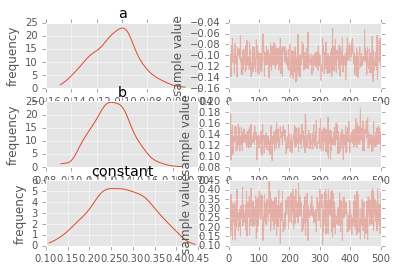

In [16]:
model.traceplot()
py.show()

#### Problem 4

Build a scatter plot view of the traceplot of the parameters. **Hint**, the easiest way is probably to put the model components, a, b, the coeffecients, and the constant in a pandas dictionary, and then call the pandas method scatter_matrix. **Another Hint**: look up the .extract() method in the PyStan docs. 

In [17]:
trace = pd.DataFrame(model.extract(['a', 'b', 'constant']))

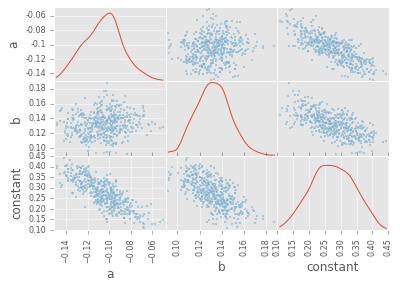

In [18]:
pd.scatter_matrix(trace[:], diagonal='kde');

#### Problem 5

Extract the coefficients from the model (read the PyStan docs if you don't know the method for this procedure, but if you did the above exercise, you should pretty much know how to do it). House those extracted coefficients in a pandas data frame

In [104]:
Coeff1 = model.extract(['a', 'b', 'constant'])
Coeff = pd.DataFrame({'a': Coeff1['a'], 'b': Coeff1['b'], 'constant': Coeff1['constant']})

#### Problem 6

This is something we haven't done last time. We're going to build a predictor function. For this we need to define a python function, and remember, for Bayesian models, we need to specify the function explicitly, and we're going to build a function that predits a logistic regression, so how should that look like? 

Also note, we are really just a simple type of "forecasting", we're not doing any validation (so not test/train sets), we're just excploring what kind of things we can possibly do with PyStan.

In [132]:
def predFunc(x):
    yhat = np.exp( x[2] + x[1]*xaxis + x[2]*xaxis )/(1+np.exp( x[2] + x[1]*xaxis + x[2]*xaxis ))
    return pd.Series({'yhat' : yhat})
 

#### Problem 7

Use the predFunction to graph the function on a X-Y axis. First define the x-axis using linspace form numpy

In [141]:
xaxis = np.linspace(1, 30);

In [142]:
ovPred = Coeff.apply(predFunc, axis = 1)


Pass the coeffecient medians to predFunc

In [143]:
ovPred = predFunc(Coeff.median()); ovPred

yhat    [0.659597844206, 0.708046868002, 0.75219089337...
dtype: object

Plot the function using pyplot

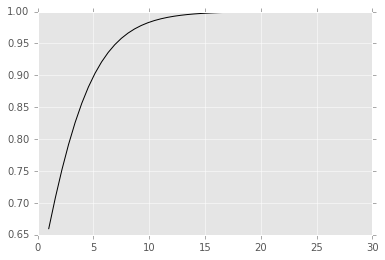

In [144]:
py.plot(xaxis, ovPred['yhat'], 'k')